In [ ]:
##########################################################################

# I acknowledge the use of ChatGPT and AI Tools in Helping me Code and Debug the work in this File

##########################################################################




In [1]:
import pandas as pd 
import numpy as np 

file_path =  "/scratch/network/mm4846/03_22_vectors_full.csv"
df_vectorized = pd.read_csv(file_path)

# df_vectorized.to_csv(file_path)

file_path = "/scratch/network/mm4846/final_returns.csv"

df_returns = pd.read_csv(file_path)


In [2]:
# df_vectorized['questions_vector'][31275]
import ast
import numpy as np
def safe_parse_vector(val):
    if isinstance(val, str) and val.strip().startswith("["):
        try:
            return ast.literal_eval(val)
        except (ValueError, SyntaxError):
            return np.nan  # or [] if you prefer empty lists
    return np.nan  # or [] for consistency

# Apply safely

column_names = df_vectorized.columns[13:]
column_names
for name in column_names: 
    df_vectorized[name] = df_vectorized[name].apply(safe_parse_vector)
df_vectorized['episodic_vector'] = df_vectorized['episodic_vector'].apply(safe_parse_vector)

In [9]:
df_returns_cap_goods['Date'] = pd.to_datetime(df_returns_cap_goods['Date'])


/tmp/ipykernel_3606377/3374559190.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_returns_cap_goods['Date'] = pd.to_datetime(df_returns_cap_goods['Date'])


In [8]:
df_cap_goods = df_vectorized[df_vectorized['group_name_mapped'] == 'Capital Goods']
df_returns_cap_goods = df_returns[df_returns['group_name_mapped'] == 'Capital Goods']

## want clusters before 2017, maybe 2016Q1-Q4
## then clusters for 2017
## then clusters for 2018

## want to do that for tickers affected by tariffs too

## analyze whether tickers affected by tariffs dispersed or stayed, and toggle



In [10]:
df_returns_cap_goods[df_returns_cap_goods['Date'].dt.year == 2016]

,Unnamed: 0,Date,Close Price,Daily Log Return,Weekly Log Return,Ticker,ticker,sector_name_mapped,group_name_mapped,ind_name_mapped,subind_name_mapped,quarter
26685,26685,2016-01-04,11.090000,0.000902,0.015448,BLDR,BLDR,Industrials,Capital Goods,Building Products,Building Products,2016Q1
26686,26686,2016-01-05,11.180000,0.008083,0.053272,BLDR,BLDR,Industrials,Capital Goods,Building Products,Building Products,2016Q1
26687,26687,2016-01-06,10.420000,-0.070399,-0.032109,BLDR,BLDR,Industrials,Capital Goods,Building Products,Building Products,2016Q1
26688,26688,2016-01-07,9.650000,-0.076769,-0.102351,BLDR,BLDR,Industrials,Capital Goods,Building Products,Building Products,2016Q1
26689,26689,2016-01-08,9.470000,-0.018829,-0.157013,BLDR,BLDR,Industrials,Capital Goods,Building Products,Building Products,2016Q1
...,...,...,...,...,...,...,...,...,...,...,...,...
1744948,1744948,2016-12-23,57.157009,0.001719,0.019438,RTX,RTX,Industrials,Capital Goods,Aerospace & Defense,Aerospace & Defense,2016Q4
1744949,1744949,2016-12-27,57.327473,0.002978,0.001442,RTX,RTX,Industrials,Capital Goods,Aerospace & Defense,Aerospace & Defense,2016Q4
1744950,1744950,2016-12-28,56.919399,-0.007144,-0.004166,RTX,RTX,Industrials,Capital Goods,Aerospace & Defense,Aerospace & Defense,2016Q4
1744951,1744951,2016-12-29,57.105354,0.003262,0.000543,RTX,RTX,Industrials,Capital Goods,Aerospace & Defense,Aerospace & Defense,2016Q4


In [101]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def cluster_stock_returns(df, n_clusters=4, date_col='Date', ticker_col='ticker', return_col='Daily Log Return'):

    # Step 1: Clean and pivot
    df_clean = df.dropna(subset=[return_col])
    returns_matrix = df_clean.pivot(index=date_col, columns=ticker_col, values=return_col)
    
    # Drop incomplete data
    returns_matrix = returns_matrix.dropna(axis=1, how='any')  # drop tickers with any NA
    returns_matrix = returns_matrix.dropna(axis=0, how='all')  # drop days with all NA
    
    if returns_matrix.shape[1] < n_clusters:
        raise ValueError("Fewer tickers than clusters — reduce n_clusters or check data.")
    
    # Prepare matrix for clustering
    X = returns_matrix.T
    X_scaled = StandardScaler().fit_transform(X)

    # === K-MEANS CLUSTERING ===
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_scaled)
    kmeans_clusters = pd.DataFrame({ticker_col: X.index, 'kmeans_cluster': kmeans_labels + 1})

    # === Combine and return ===
    cluster_df =kmeans_clusters

    return cluster_df

def measure_cluster_concentration(cluster_df, tickers_of_interest, cluster_col='kmeans_cluster'):
    subset = cluster_df[cluster_df['ticker'].isin(tickers_of_interest)]
    total = len(subset)
    cluster_counts = subset[cluster_col].value_counts().sort_index()

    spread = cluster_counts.count()  # how many different clusters they're spread over
    most_common_count = cluster_counts.max()
    concentration = most_common_count / total if total > 0 else np.nan

    return {
        "total": total,
        "unique_clusters": spread,
        "most_common_cluster_size": most_common_count,
        "concentration_ratio": concentration,
        "cluster_distribution": cluster_counts.to_dict()
    }

def get_control_tickers(cluster_df, tickers_of_interest):
    return cluster_df[~cluster_df['ticker'].isin(tickers_of_interest)]['ticker'].unique()


df_returns_cap_goods_2016 = df_returns_cap_goods[df_returns_cap_goods['Date'].dt.year == 2019]
cluster_cap_goods_2016 = cluster_stock_returns(df_returns_cap_goods_2016, n_clusters=8)

df_returns_cap_goods_2017 = df_returns_cap_goods[df_returns_cap_goods['Date'].dt.year == 2020]
cluster_cap_goods_2017 = cluster_stock_returns(df_returns_cap_goods_2017, n_clusters=8)

df_returns_cap_goods_2018 = df_returns_cap_goods[df_returns_cap_goods['Date'].dt.year == 2021]
cluster_cap_goods_2018 = cluster_stock_returns(df_returns_cap_goods_2018, n_clusters=8)





In [115]:
# clusters_2016 = cluster_cap_goods_2016[cluster_cap_goods_2016['ticker'].isin(tickers_2018)].copy()
# clusters_2017 = cluster_cap_goods_2017[cluster_cap_goods_2017['ticker'].isin(tickers_2018)].copy()
# clusters_2018 = cluster_cap_goods_2018[cluster_cap_goods_2018['ticker'].isin(tickers_2018)].copy()

# # Rename for clarity
# clusters_2016 = clusters_2016.rename(columns={'kmeans_cluster': 'cluster_2016'})
# clusters_2017 = clusters_2017.rename(columns={'kmeans_cluster': 'cluster_2017'})
# clusters_2018 = clusters_2018.rename(columns={'kmeans_cluster': 'cluster_2018'})

# # Merge on ticker
# clusters_combined = clusters_2016[['ticker', 'cluster_2016']] \
#     .merge(clusters_2017[['ticker', 'cluster_2017']], on='ticker', how='outer') \
#     .merge(clusters_2018[['ticker', 'cluster_2018']], on='ticker', how='outer')

# # Display result
# print(clusters_combined)


results_2016 = measure_cluster_concentration(cluster_cap_goods_2016, tickers_2018)
results_2017 = measure_cluster_concentration(cluster_cap_goods_2017, tickers_2018)
results_2018 = measure_cluster_concentration(cluster_cap_goods_2018, tickers_2018)

control_2016 = get_control_tickers(cluster_cap_goods_2016, tickers_2018)
control_2017 = get_control_tickers(cluster_cap_goods_2017, tickers_2018)
control_2018 = get_control_tickers(cluster_cap_goods_2018, tickers_2018)

results_control_2016 = measure_cluster_concentration(cluster_cap_goods_2016, control_2016)
results_control_2017 = measure_cluster_concentration(cluster_cap_goods_2017, control_2017)
results_control_2018 = measure_cluster_concentration(cluster_cap_goods_2018, control_2018)


print("2016:", results_2016)
print("2017:", results_2017)
print("2018:", results_2018)


2016: {'total': 22, 'unique_clusters': 4, 'most_common_cluster_size': 10, 'concentration_ratio': 0.45454545454545453, 'cluster_distribution': {1: 1, 2: 2, 5: 9, 6: 10}}
2017: {'total': 22, 'unique_clusters': 5, 'most_common_cluster_size': 12, 'concentration_ratio': 0.5454545454545454, 'cluster_distribution': {1: 1, 2: 1, 3: 1, 4: 7, 8: 12}}
2018: {'total': 22, 'unique_clusters': 6, 'most_common_cluster_size': 16, 'concentration_ratio': 0.7272727272727273, 'cluster_distribution': {2: 1, 3: 1, 4: 1, 5: 16, 6: 1, 7: 2}}


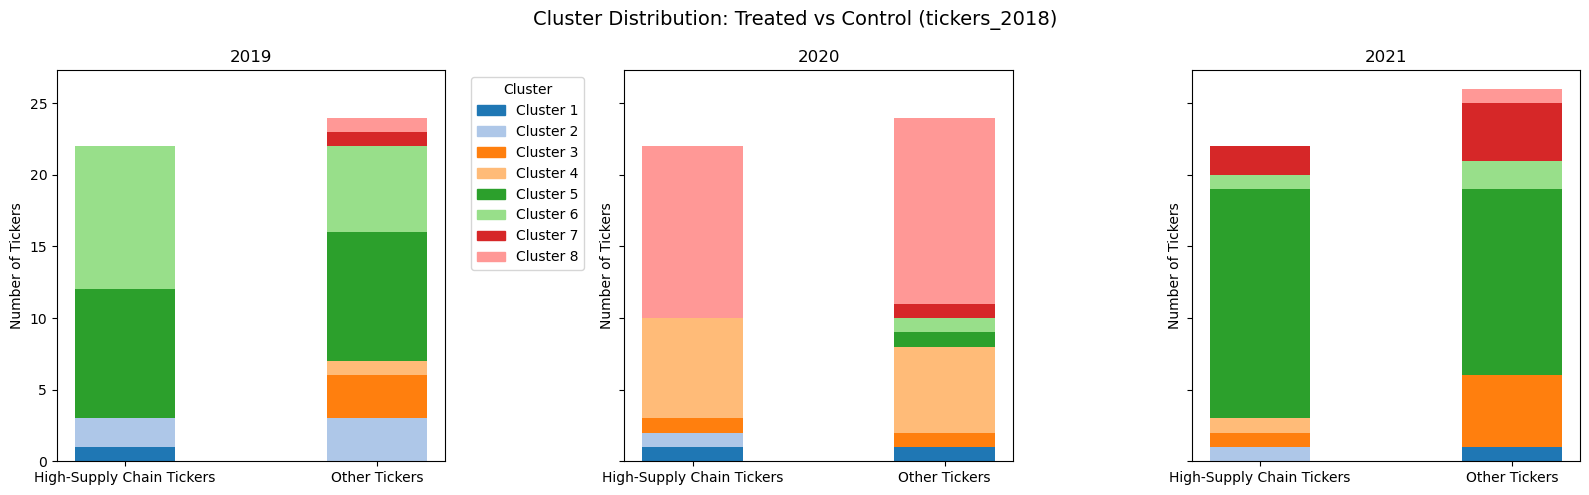

In [116]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_stacked_bars(treated_df, control_df, label):
    fig, axs = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

    # Get all unique clusters across all years
    all_clusters = sorted(set(treated_df.index).union(control_df.index))

    # Assign consistent colors
    cluster_colors = {cluster: cm.tab20(i % 20) for i, cluster in enumerate(all_clusters)}

    for i, year in enumerate(['2019', '2020', '2021']):
        treated_vals = treated_df.get(year, pd.Series()).sort_index()
        control_vals = control_df.get(year, pd.Series()).sort_index()

        # Reindex so both have same clusters
        treated_vals = treated_vals.reindex(all_clusters, fill_value=0)
        control_vals = control_vals.reindex(all_clusters, fill_value=0)

        bottom_t, bottom_c = 0, 0
        for cluster in all_clusters:
            color = cluster_colors[cluster]
            axs[i].bar('Treated', treated_vals[cluster], bottom=bottom_t, color=color, width=0.4)
            axs[i].bar('Control', control_vals[cluster], bottom=bottom_c, color=color, width=0.4)
            bottom_t += treated_vals[cluster]
            bottom_c += control_vals[cluster]

        axs[i].set_title(f"{year}")
        axs[i].set_ylabel("Number of Tickers")
        axs[i].set_xticks([0, 1])
        axs[i].set_xticklabels(['High-Supply Chain Tickers', 'Other Tickers'])

    # Create custom legend
    handles = [plt.Rectangle((0, 0), 1, 1, color=cluster_colors[c]) for c in all_clusters]
    labels = [f"Cluster {c}" for c in all_clusters]
    axs[0].legend(handles, labels, title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

    fig.suptitle(f"Cluster Distribution: Treated vs Control ({label})", fontsize=14)
    plt.tight_layout()
    plt.show()




treated_df = pd.DataFrame({
    '2019': results_2016['cluster_distribution'],
    '2020': results_2017['cluster_distribution'],
    '2021': results_2018['cluster_distribution'],
}).fillna(0).astype(int).sort_index()

control_df = pd.DataFrame({
    '2019': results_control_2016['cluster_distribution'],
    '2020': results_control_2017['cluster_distribution'],
    '2021': results_control_2018['cluster_distribution'],
}).fillna(0).astype(int).sort_index()


plot_stacked_bars(treated_df, control_df, label="tickers_2018")

In [102]:
# years = ['2016', '2017', '2018']
# concentrations = [
#     results_2016['concentration_ratio'],
#     results_2017['concentration_ratio'],
#     results_2018['concentration_ratio']
# ]




# plt.figure(figsize=(8, 5))
# plt.bar(years, concentrations, color='skyblue')
# plt.ylim(0, 1)
# plt.ylabel("Concentration Ratio")
# plt.title("How Concentrated Are Selected Tickers in a Single Cluster?")
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

# cluster_dist_df = pd.DataFrame({
#     '2016': results_2016['cluster_distribution'],
#     '2017': results_2017['cluster_distribution'],
#     '2018': results_2018['cluster_distribution'],
# }).fillna(0).astype(int).sort_index()

# # Plot
# cluster_dist_df.T.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')
# plt.title("Distribution of Selected Tickers Across Clusters (per Year)")
# plt.xlabel("Year")
# plt.ylabel("Number of Tickers")
# plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()


# import seaborn as sns

# plt.figure(figsize=(8, 4))
# sns.heatmap(cluster_dist_df, annot=True, fmt='d', cmap='Blues')
# plt.title("Cluster Distribution of Selected Tickers (Heatmap)")
# plt.xlabel("Year")
# plt.ylabel("Cluster")
# plt.tight_layout()
# plt.show()

In [117]:
def tickers_with_mentions(
    df,
    topic="tariffs",
    vector_col="questions_vector",
    start_quarter=None,
    end_quarter=None
):
    # Get topic index (0-based)
    reverse_mapping = {v: k for k, v in topic_mapping.items()}
    if topic not in reverse_mapping:
        raise ValueError(f"Topic '{topic}' not found in topic_mapping.")
    idx = reverse_mapping[topic] - 1

    # Filter by quarter
    df_filtered = df.copy()
    # df_filtered["assigned_quarter"]
    if start_quarter:
        df_filtered = df_filtered[df_filtered["assigned_quarter"] >= start_quarter]
    if end_quarter:
        df_filtered = df_filtered[df_filtered["assigned_quarter"] <= end_quarter]

    # Find rows with > 0 mentions
    has_mention = df_filtered[vector_col].apply(
        lambda vec: isinstance(vec, list) and len(vec) > idx and vec[idx] > 2
    )

    tickers = df_filtered.loc[has_mention, "ticker"].unique()
    return sorted(tickers)


tickers_2016 = tickers_with_mentions(df=df_cap_goods, topic="supply_chain", vector_col="questions_vector", start_quarter="2019Q1", end_quarter="2019Q4"
)

tickers_2017 = tickers_with_mentions(df=df_cap_goods, topic="supply_chain", vector_col="questions_vector", start_quarter="2020Q1", end_quarter="2020Q4"
)
tickers_2018 = tickers_with_mentions(df=df_cap_goods, topic="supply_chain", vector_col="questions_vector", start_quarter="2021Q1", end_quarter="2021Q4"
)

print(len(tickers_2018))
print(tickers_2016)
print(tickers_2017)

# print("Q&A tickers (2016–2020):", len(all_tickers_qna))
# print("Presentation tickers (2016–2020):", len(tickers_pres))

# tickers_both = list(set(all_tickers_qna) & set(tickers_pres))
# print(tickers_both)
# print(len(tickers_both))


37
['EMR', 'MAS']
['DOV', 'ETN', 'PCAR', 'PNR', 'XYL']


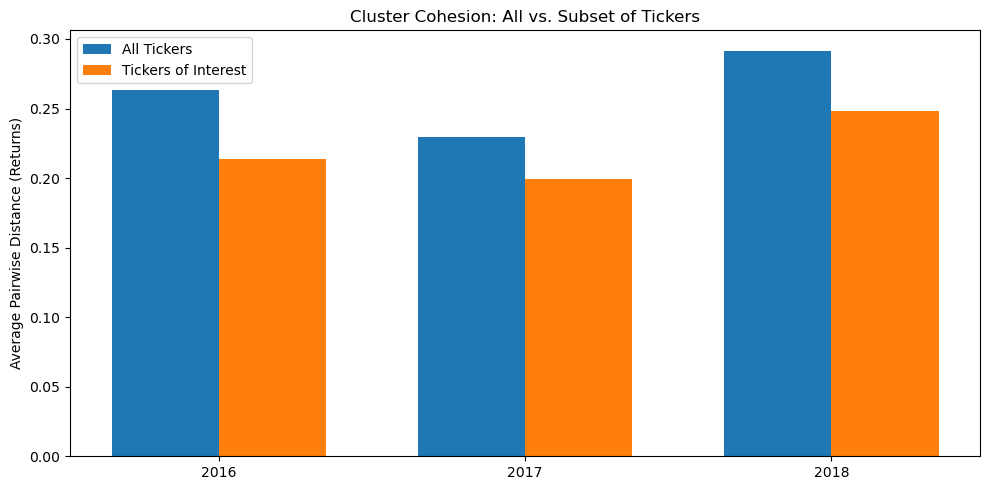

In [100]:
from sklearn.metrics import pairwise_distances
import numpy as np

def compute_avg_distance_and_correlation(df_year, tickers_subset, return_col='Daily Log Return'):
    # Pivot: rows = date, columns = ticker
    pivot = df_year.pivot(index='Date', columns='ticker', values=return_col)
    pivot = pivot.dropna(axis=1, how='any')
    pivot = pivot.dropna(axis=0, how='all')

    # Full matrix
    X_full = pivot.T.values

    # Subset
    common_subset = [t for t in tickers_subset if t in pivot.columns]
    X_subset = pivot[common_subset].T.values

    # === Euclidean distances (optional)
    dists_full = pairwise_distances(X_full)
    dists_subset = pairwise_distances(X_subset)

    def avg_upper(mat):
        n = mat.shape[0]
        return mat[np.triu_indices(n, k=1)].mean() if n > 1 else np.nan

    avg_dist_full = avg_upper(dists_full)
    avg_dist_subset = avg_upper(dists_subset)

    # === Correlation analysis
    corr_subset = np.corrcoef(X_subset)
    avg_corr_subset = corr_subset[np.triu_indices_from(corr_subset, k=1)].mean() if X_subset.shape[0] > 1 else np.nan

    return avg_dist_full, avg_dist_subset, avg_corr_subset, len(common_subset)
tickers_2018_set = set(tickers_2018)

d_2016_all, d_2016_subset, n_2016 = compute_avg_distance(df_returns_cap_goods_2016, tickers_2018_set)
d_2017_all, d_2017_subset, n_2017 = compute_avg_distance(df_returns_cap_goods_2017, tickers_2018_set)
d_2018_all, d_2018_subset, n_2018 = compute_avg_distance(df_returns_cap_goods_2018, tickers_2018_set)

import matplotlib.pyplot as plt

labels = ['2016', '2017', '2018']
all_vals = [d_2016_all, d_2017_all, d_2018_all]
subset_vals = [d_2016_subset, d_2017_subset, d_2018_subset]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, all_vals, width, label='All Tickers')
plt.bar(x + width/2, subset_vals, width, label='Tickers of Interest')

plt.ylabel("Average Pairwise Distance (Returns)")
plt.title("Cluster Cohesion: All vs. Subset of Tickers")
plt.xticks(x, labels)
plt.legend()
plt.tight_layout()
plt.show()

In [4]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from typing import List, Dict

# =============================
# === Core Clustering Logic ===
# =============================
def cluster_stock_returns(df, n_clusters=4, date_col='Date', ticker_col='ticker', return_col='Daily Log Return') -> pd.DataFrame:
    pivot = df.pivot(index=date_col, columns=ticker_col, values=return_col)
    pivot = pivot.dropna(axis=1, how='any').dropna(axis=0, how='all')
    if pivot.shape[1] < n_clusters:
        raise ValueError("Fewer tickers than clusters.")
    X_scaled = StandardScaler().fit_transform(pivot.T)
    labels = KMeans(n_clusters=n_clusters, random_state=42).fit_predict(X_scaled)
    return pd.DataFrame({ticker_col: pivot.columns, 'kmeans_cluster': labels + 1})

# ===================================
# === Measure Cluster Cohesion ===
# ===================================
def measure_cluster_concentration(cluster_df, tickers: List[str], cluster_col='kmeans_cluster') -> Dict:
    subset = cluster_df[cluster_df['ticker'].isin(tickers)]
    counts = subset[cluster_col].value_counts().sort_index()
    total = len(subset)
    return {
        "total": total,
        "unique_clusters": counts.count(),
        "most_common_cluster_size": counts.max(),
        "concentration_ratio": counts.max() / total if total > 0 else np.nan,
        "cluster_distribution": counts.to_dict()
    }

def get_control_tickers(cluster_df, tickers_of_interest):
    return cluster_df[~cluster_df['ticker'].isin(tickers_of_interest)]['ticker'].unique()

# ===================================
# === Extract Mentioning Tickers ===
# ===================================
def tickers_with_mentions(df, topic, vector_col="questions_vector", start_quarter=None, end_quarter=None):
    reverse_mapping = {v: k for k, v in topic_mapping.items()}
    idx = reverse_mapping.get(topic, None)
    if idx is None:
        raise ValueError(f"Topic '{topic}' not in mapping.")
    idx -= 1
    df_filtered = df.copy()
    if start_quarter:
        df_filtered = df_filtered[df_filtered['assigned_quarter'] >= start_quarter]
    if end_quarter:
        df_filtered = df_filtered[df_filtered['assigned_quarter'] <= end_quarter]
    mask = df_filtered[vector_col].apply(lambda vec: isinstance(vec, list) and len(vec) > idx and vec[idx] > 1)
    return sorted(df_filtered.loc[mask, 'ticker'].unique())

# ===================================
# === Plotting Logic ===
# ===================================
def plot_stacked_bars(treated_df, control_df, label):
    fig, axs = plt.subplots(1, len(treated_df.columns), figsize=(5 * len(treated_df.columns), 5), sharey=True)
    years = treated_df.columns
    all_clusters = sorted(set(treated_df.index).union(control_df.index))
    colors = {c: cm.tab20(i % 20) for i, c in enumerate(all_clusters)}

    for i, year in enumerate(years):
        treated = treated_df.get(year, pd.Series()).reindex(all_clusters, fill_value=0).sort_index()
        control = control_df.get(year, pd.Series()).reindex(all_clusters, fill_value=0).sort_index()
        bottom_t, bottom_c = 0, 0
        for c in all_clusters:
            axs[i].bar('Treated', treated[c], bottom=bottom_t, color=colors[c], width=0.4)
            axs[i].bar('Control', control[c], bottom=bottom_c, color=colors[c], width=0.4)
            bottom_t += treated[c]
            bottom_c += control[c]
        axs[i].set_title(f"{year}")
        axs[i].set_ylabel("Number of Tickers")
        axs[i].set_xticks([0, 1])
        axs[i].set_xticklabels(['High-' + label, 'Other'])

    handles = [plt.Rectangle((0, 0), 1, 1, color=colors[c]) for c in all_clusters]
    labels = [f"Cluster {c}" for c in all_clusters]
    axs[0].legend(handles, labels, title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    fig.suptitle(f"Cluster Distribution: Treated vs Control ({label})", fontsize=14)
    plt.tight_layout()
    plt.show()

# ===================================
# === Full Pipeline Driver ===
# ===================================
def run_cluster_analysis_pipeline(df_returns_by_year, df_topic_vectors, topic, years, n_clusters=6, vector_col="questions_vector"):
    treated_results = {}
    control_results = {}
    cluster_results = {}

    # Get tickers with mentions across all years
    all_tickers = set()
    for year in years:
        tickers = tickers_with_mentions(
            df=df_topic_vectors,
            topic=topic,
            vector_col=vector_col,
            start_quarter=f"{year}Q1",
            end_quarter=f"{year}Q4"
        )
        all_tickers.update(tickers)

    for year in years:
        df_year = df_returns_by_year[df_returns_by_year['Date'].dt.year == year]
        clustered = cluster_stock_returns(df_year, n_clusters=n_clusters)
        treated_results[year] = measure_cluster_concentration(clustered, list(all_tickers))
        control_results[year] = measure_cluster_concentration(clustered, get_control_tickers(clustered, list(all_tickers)))
        cluster_results[year] = clustered

    # Format results for plotting
    treated_df = pd.DataFrame({str(year): treated_results[year]['cluster_distribution'] for year in years}).fillna(0).astype(int).sort_index()
    control_df = pd.DataFrame({str(year): control_results[year]['cluster_distribution'] for year in years}).fillna(0).astype(int).sort_index()

    plot_stacked_bars(treated_df, control_df, label=topic)

    return treated_results, control_results, cluster_results


In [5]:
treated_results, control_results, cluster_dfs = run_cluster_analysis_pipeline(
    df_returns_by_year=df_returns_cap_goods,
    df_topic_vectors=df_cap_goods,
    topic="tariffs",
    years=[2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025],
    n_clusters=8
)

NameError: name 'df_returns_cap_goods' is not defined

In [7]:
topic_mapping = {
    1: 'ai',
    2: 'buyback',
    3: 'capex',
    4: 'climate',
    5: 'commodity_price',
    6: 'consumer_demand',
    7: 'currency_fluctuations_hedging',
    8: 'cybersecurity_data_protection',
    9: 'debt',
    10: 'dividend',
    11: 'esg_sustainability',
    12: 'geopolitical',
    13: 'geopolitical_2',
    14: 'guidance_forecasts',
    15: 'inflation',
    16: 'interest_rates',
    17: 'labor',
    18: 'labor_cost',
    19: 'liquidity_cash_flow',
    20: 'operational',
    21: 'outperform',
    22: 'pandemic',
    23: 'political',
    24: 'rd',
    25: 'regulation',
    26: 'reshoring',
    27: 'supply_chain',
    28: 'tariffs',
    29: 'tax_strategy',
    30: 'other'
}
